In [2]:
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, RandomRotation, ColorJitter, Resize, ToTensor, Normalize
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
def visualize_attention(video_frames, spatial_weights, temporal_weights):
    """
    Visualize attention over video frames, spatial weights, and temporal weights.

    Args:
        video_frames (torch.Tensor): Shape [batch_size, 3, num_frames, height, width].
        spatial_weights (torch.Tensor): Shape [batch_size, num_frames, num_frames].
        temporal_weights (torch.Tensor): Shape [batch_size, num_frames, num_frames].
    """
    num_frames, height, width = video_frames.shape[2], video_frames.shape[3], video_frames.shape[4]

    # Normalize spatial weights for visualization
    spatial_weights_normalized = spatial_weights.cpu().detach().numpy()
    temporal_weights_normalized = temporal_weights.cpu().detach().numpy()

    # Visualize frames
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    for i in range(num_frames):
        frame = video_frames[0, :, i, :, :].permute(1, 2, 0).cpu().numpy()
        axes[i].imshow((frame - frame.min()) / (frame.max() - frame.min()))  # Normalize frame
        axes[i].set_title(f"Frame {i + 1}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    # Visualize spatial attention for the first batch
    plt.figure(figsize=(8, 6))
    plt.imshow(spatial_weights_normalized[0], cmap='hot', interpolation='nearest')
    plt.title("Spatial Attention (Frame-to-Frame Relationships)")
    plt.colorbar()
    plt.show()

    # Visualize temporal attention for the first batch
    plt.figure(figsize=(8, 6))
    plt.imshow(temporal_weights_normalized[0], cmap='hot', interpolation='nearest')  # First batch only
    plt.title("Temporal Attention (Frame-to-Frame Relationships)")
    plt.colorbar()
    plt.show()


In [4]:
# Dataset class for images
class ActionVideoFromImagesDataset(Dataset):
    def __init__(self, root_dir, num_frames=16, transform=None):
        """
        Args:
            root_dir (str): Path to the root directory containing action label folders.
            num_frames (int): Number of frames to sample per pseudo-video.
            transform (callable, optional): Transform to apply to each frame.
        """
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.transform = transform
        self.data = []
        self.labels = []
        self.classes = os.listdir(root_dir)

        # Load dataset: Store paths of image files and corresponding labels
        for label, action in enumerate(self.classes):
            action_dir = os.path.join(root_dir, action)
            image_files = sorted(os.listdir(action_dir))  # Sort for consistent sequence
            self.data.append((image_files, label, action_dir))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns:
            frames (torch.Tensor): Tensor of shape [C, D, H, W].
            label (int): Action label.
        """
        image_files, label, action_dir = self.data[idx]

        # Sample `num_frames` images
        if len(image_files) >= self.num_frames:
            selected_files = image_files[:self.num_frames]  # Sequential sampling
        else:
            selected_files = image_files  # Use all available images

        frames = []
        for file in selected_files:
            img_path = os.path.join(action_dir, file)
            img = Image.open(img_path).convert("RGB")  # Ensure RGB format
            if self.transform:
                img = self.transform(img)
            frames.append(img)

        # Pad with empty frames if fewer than `num_frames`
        while len(frames) < self.num_frames:
            frames.append(torch.zeros_like(frames[0]))

        # Stack frames along the temporal depth dimension
        frames = torch.stack(frames, dim=0)  # Shape: [D, C, H, W]
        frames = frames.permute(1, 0, 2, 3)  # Rearrange to [C, D, H, W]

        return frames, label



class ActionVideoDatasetSingle(Dataset):
    def __init__(self, video_dir, num_frames=16, transform=None):
        self.video_dir = video_dir
        self.num_frames = num_frames
        self.transform = transform
        self.classes = os.listdir(video_dir)  # List of action folder names
        self.label_to_class = {i: cls for i, cls in enumerate(self.classes)}  # Map index to folder name

        # Select one video per action label folder
        self.video_files = []
        for label, cls in enumerate(self.classes):
            action_folder = os.path.join(video_dir, cls)
            videos = [f for f in os.listdir(action_folder) if f.endswith('.mp4')]
            if videos:
                self.video_files.append((os.path.join(action_folder, videos[0]), label))

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path, label = self.video_files[idx]
        cap = cv2.VideoCapture(video_path)
        frames = []
        while len(frames) < self.num_frames:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)  # Convert NumPy array to PIL image
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
        cap.release()

        # If fewer frames than num_frames, pad with zeros
        while len(frames) < self.num_frames:
            frames.append(torch.zeros_like(frames[0]))

        # Stack frames along the depth dimension
        frames = torch.stack(frames, dim=0)  # Shape: [D, C, H, W]
        frames = frames.permute(1, 0, 2, 3)  # Rearrange to [C, D, H, W]

        # print(f"Frame shape: {frames.shape}")  # Should be [3, num_frames, height, width]
        return frames, label, video_path

In [5]:
# Transforms
image_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

video_transform = Compose([
    Resize((224, 224)),
    RandomHorizontalFlip(p=0.5),
    RandomCrop((200, 200), pad_if_needed=True),  # Adds spatial variety
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


test_dataset = ActionVideoDatasetSingle(video_dir='resized_videos', num_frames=16, transform=video_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)  # Adjust batch_size if needed


# Parameters for class balancing
target_count = 15  # Define the target number of images per class

# Load datasets with augmentation for imbalance correction
train_dataset = ActionVideoFromImagesDataset(
    root_dir='action_sp',
    num_frames=16,
    transform=image_transform
)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
test_dataset = ActionVideoDatasetSingle(video_dir='resized_videos', transform=video_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Confirm updated dataset statistics
print(f"Number of training samples: {len(train_dataset)}")

Number of training samples: 21


Shape of spatial weights: torch.Size([6, 6, 6])


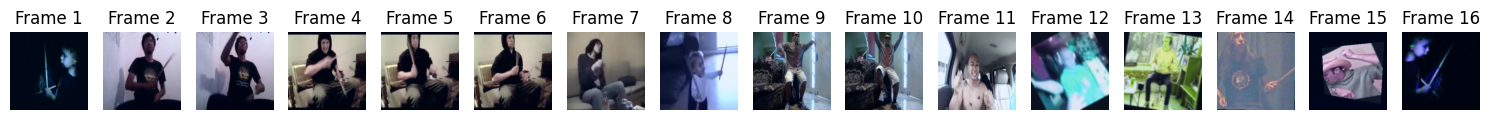

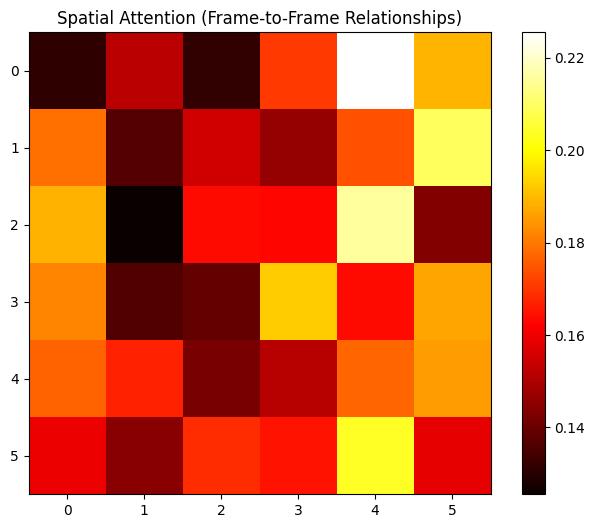

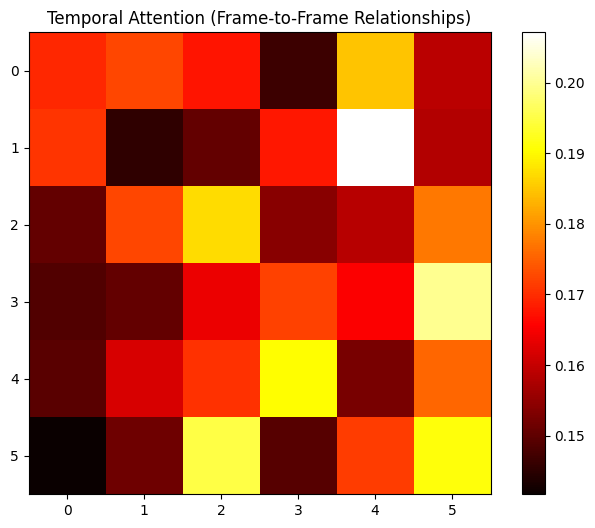

In [10]:
for inputs, labels in train_loader:
    inputs = inputs.to(device)

    # Forward pass through the model
    outputs, spatial_weights, temporal_weights = model(inputs)
    print(f"Shape of spatial weights: {spatial_weights.shape}")

    # Visualize attention for the first batch
    visualize_attention(inputs, spatial_weights, temporal_weights)
    break


In [7]:
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import Compose, RandomCrop, RandomHorizontalFlip, RandomRotation, ColorJitter, Resize, ToTensor, Normalize
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from PIL import Image
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [8]:
class RViT(nn.Module):
    def __init__(self, num_classes, hidden_dim, num_layers, frame_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

        # Patch embedding
        self.patch_embedding = nn.Conv3d(3, hidden_dim, kernel_size=(3, 8, 8), stride=(3, 4, 4), padding=(1, 2, 2))
        self.position_encoding = nn.Parameter(torch.randn(1, hidden_dim, 1, 56, 56), requires_grad=True)

        # Add relative positional embeddings for temporal modeling
        self.relative_positional_encoding = nn.Parameter(torch.randn(1, hidden_dim, 1, frame_dim[1], frame_dim[2]), requires_grad=True)

        # Spatiotemporal Transformer Units
        self.rvit_units = nn.ModuleList([RViTUnitWithTemporal(hidden_dim) for _ in range(num_layers)])
        
        # Classifier
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # print(f"Input shape to patch embedding: {x.shape}")
        patches = self.patch_embedding(x)
        # print(f"Shape after patch embedding: {patches.shape}")

        # Add positional encoding
        _, _, depth, height, width = patches.shape
        pos_encoding = nn.functional.interpolate(
            self.position_encoding,
            size=(depth, height, width),
            mode='trilinear',
            align_corners=False
        )
        patches += pos_encoding

        # Resize relative positional encoding to match patch dimensions
        relative_pos_encoding = nn.functional.interpolate(
            self.relative_positional_encoding,
            size=(depth, height, width),
            mode='trilinear',
            align_corners=False
        )
        patches += relative_pos_encoding

        # Flatten spatial dimensions for temporal processing
        batch_size, hidden_dim, depth, height, width = patches.size()
        patches = patches.permute(0, 2, 1, 3, 4).reshape(batch_size, depth, hidden_dim, -1)
        patches = patches.mean(-1)  # Average pooling across spatial dimensions

        # Recurrent Spatiotemporal Processing
        spatial_weights, temporal_weights = None, None
        for unit in self.rvit_units:
            patches, spatial_weights, temporal_weights = unit(patches)

        # Classification
        h_last = patches.mean(dim=1)  # Global average pooling over the sequence length
        logits = self.classifier(h_last)

        return logits, spatial_weights, temporal_weights






class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.Wq = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wk = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wv = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.scale = hidden_dim ** -0.5

    def forward(self, x, h):
        # Compute queries, keys, and values
        q = self.Wq(x)
        k = self.Wk(h)
        v = self.Wv(h)
        
        # Compute scaled dot-product attention
        attn = torch.softmax((q * k).sum(dim=1, keepdim=True) * self.scale, dim=-1)
        output = attn * v  # Apply attention weights to values
        
        return output
        
class LinearAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.Wq = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wk = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wv = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wo = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)

    def forward(self, x, h):
        # Compute queries, keys, and values
        q = self.Wq(x)  # Shape: [batch_size, hidden_dim, depth, height, width]
        k = self.Wk(h)  # Shape: [batch_size, hidden_dim, depth, height, width]
        v = self.Wv(h)  # Shape: [batch_size, hidden_dim, depth, height, width]
        
        # Reshape q and k for attention computation
        q = q.flatten(start_dim=2)  # Shape: [batch_size, hidden_dim, depth*height*width]
        k = k.flatten(start_dim=2)  # Shape: [batch_size, hidden_dim, depth*height*width]
        v = v.flatten(start_dim=2)  # Shape: [batch_size, hidden_dim, depth*height*width]

        # Compute attention weights
        attn_weights = torch.bmm(q.transpose(1, 2), k)  # Shape: [batch_size, depth*height*width, depth*height*width]
        attn_weights = attn_weights / (k.size(1) ** 0.5)  # Scale by sqrt of hidden_dim
        attn_weights = torch.softmax(attn_weights, dim=-1)  # Apply softmax over last dimension

        # Apply attention weights to values
        attn_output = torch.bmm(v, attn_weights.transpose(1, 2))  # Shape: [batch_size, hidden_dim, depth*height*width]
        
        # Reshape back to 3D
        attn_output = attn_output.view_as(h)  # Shape: [batch_size, hidden_dim, depth, height, width]

        # Final projection to match the input shape
        output = self.Wo(attn_output)  # Shape: [batch_size, hidden_dim, depth, height, width]
        return output

class SpatiotemporalAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.spatial_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8, batch_first=True)
        self.temporal_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8, batch_first=True)
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        # x: [batch_size, sequence_length, hidden_dim]
        if x.ndim != 3:
            raise ValueError(f"Expected input shape [batch_size, sequence_length, hidden_dim], got {x.shape}")
        # print(f"Input shape to spatial attention: {x.shape}")

        # Spatial attention
        spatial_out, spatial_weights = self.spatial_attention(x, x, x)
        spatial_out = self.layer_norm1(x + spatial_out)   # Add & Norm

        # Temporal attention
        temporal_out, temporal_weights = self.temporal_attention(spatial_out, spatial_out, spatial_out)
        temporal_out = self.layer_norm2(spatial_out + temporal_out)  # Add & Norm

        return temporal_out, spatial_weights, temporal_weights



class RViTUnitWithTemporal(nn.Module):
    def __init__(self, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.spatial_temporal_block = SpatiotemporalAttention(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        # x: [batch_size, sequence_length, hidden_dim]
        if x.ndim != 3:
            raise ValueError(f"Expected input shape [batch_size, sequence_length, hidden_dim], got {x.shape}")

        # Spatiotemporal attention
        attention_out, spatial_weights, temporal_weights = self.spatial_temporal_block(x)
        attention_out = self.dropout(attention_out)

        # Feedforward network
        ffn_out = self.ffn(attention_out)
        output = self.layer_norm(attention_out + ffn_out)  # Add & Norm

        return output, spatial_weights, temporal_weights


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RViT(num_classes=21, hidden_dim=256, num_layers=6, frame_dim=(3, 224, 224)).to(device)
# depth 6 or 8 good

In [11]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

setting of lr=2e-5, weight_decay=2e-4 with hidden_dim=256, num_layers=4 was solid
setting of lr=2e-5, weight_decay=2e-3 with hidden_dim=256, num_layers=4 was best

Epoch 1: Loss = 3.193981, LR = 1.809017e-05
Epoch 2: Loss = 2.977666, LR = 1.707107e-05
Epoch 3: Loss = 2.918460, LR = 1.587785e-05
Epoch 4: Loss = 2.862888, LR = 1.453990e-05
Epoch 5: Loss = 2.825007, LR = 1.309017e-05
Epoch 6: Loss = 2.681319, LR = 1.156434e-05
Epoch 7: Loss = 2.747268, LR = 1.000000e-05
Epoch 8: Loss = 2.737520, LR = 8.435655e-06
Epoch 9: Loss = 2.730136, LR = 6.909830e-06
Epoch 10: Loss = 2.546214, LR = 5.460095e-06
Epoch 11: Loss = 2.703677, LR = 4.122147e-06
Epoch 12: Loss = 2.650250, LR = 2.928932e-06
Epoch 13: Loss = 2.553523, LR = 1.909830e-06
Epoch 14: Loss = 2.714196, LR = 1.089935e-06
Epoch 15: Loss = 2.524615, LR = 4.894348e-07
Epoch 16: Loss = 2.739665, LR = 1.231166e-07
Epoch 17: Loss = 2.562816, LR = 2.000000e-05
Epoch 18: Loss = 2.485888, LR = 1.996917e-05
Epoch 19: Loss = 2.603752, LR = 1.987688e-05
Epoch 20: Loss = 2.379680, LR = 1.972370e-05
Epoch 21: Loss = 2.353177, LR = 1.951057e-05
Epoch 22: Loss = 2.366505, LR = 1.923880e-05
Epoch 23: Loss = 2.

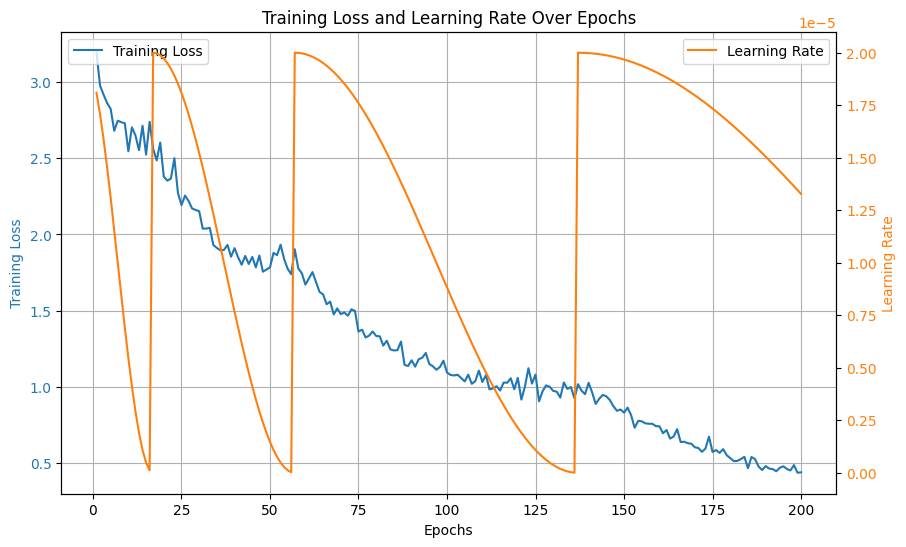

In [16]:
import matplotlib.pyplot as plt

# Initialize optimizer, criterion, and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=2e-3)  # Use AdamW for stability
criterion = nn.CrossEntropyLoss()
auxiliary_loss = nn.CosineSimilarity(dim=1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2)  # Fixed import issue

# Store loss values and learning rates for monitoring
losses = []
lrs = []

for epoch in range(200):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs, spatial_weights, temporal_weights = model(inputs)
        main_loss = criterion(outputs, labels)

        # Add auxiliary loss
        aux_loss = 0
        if spatial_weights is not None and temporal_weights is not None:
            aux_loss += (1 - auxiliary_loss(spatial_weights, temporal_weights).mean())  # Encourage similarity

        loss = main_loss + 0.1 * aux_loss  # Combine main and auxiliary loss
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

    # Adjust learning rate
    scheduler.step(epoch + len(train_loader))
    avg_loss = total_loss / len(train_loader)

    # Record training loss and learning rate
    losses.append(avg_loss)
    lrs.append(scheduler.get_lr()[0])  # Get the current LR

    print(f"Epoch {epoch + 1}: Loss = {avg_loss:.6f}, LR = {scheduler.get_lr()[0]:.6e}")

# Plot training loss and learning rate
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot loss
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training Loss", color="tab:blue")
ax1.plot(range(1, len(losses) + 1), losses, label="Training Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.legend(loc="upper left")
ax1.grid()

# Plot learning rate on a secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Learning Rate", color="tab:orange")
ax2.plot(range(1, len(lrs) + 1), lrs, label="Learning Rate", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")
ax2.legend(loc="upper right")

plt.title("Training Loss and Learning Rate Over Epochs")
plt.show()


In [18]:
import os

# Define class names dynamically based on the dataset
root_dir = "action_sp"  # Replace with the actual root directory
class_names = sorted(os.listdir(root_dir))  # Sorted to match class indices
print("Class Names:", class_names)

# Validation function
def validate_with_softmax(model, test_loader, device, class_names, top_k=3):
    model.eval()
    results = []
    output_file = "validation_results.txt"  # Define the output file name

    with open(output_file, "w") as file:  # Open the file for writing
        with torch.no_grad():
            for inputs, labels, video_path in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                # Compute softmax probabilities
                logits = outputs[0]  # Extract the first element (logits) from the tuple
                probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities

                top_probs, top_classes = probs.topk(top_k, dim=1)  # Get top-k predictions
                
                # Collect results
                for i in range(len(video_path)):
                    video_name = video_path[i]
                    true_label = class_names[labels[i].item()]
                    predicted_probs = top_probs[i].cpu().numpy()
                    predicted_classes = [class_names[idx] for idx in top_classes[i].cpu().numpy()]
                    
                    result = {
                        "Video": video_name,
                        "True Label": true_label,
                        "Predicted Classes": predicted_classes,
                        "Probabilities": predicted_probs,
                    }
                    results.append(result)
                    
                    # Write to file
                    file.write(f"Video: {video_name}\n")
                    file.write(f"True Label: {true_label}\n")
                    file.write("Predicted Classes with Probabilities:\n")
                    for cls, prob in zip(predicted_classes, predicted_probs):
                        file.write(f"  {cls}: {prob:.4f}\n")
                    file.write("-" * 30 + "\n")
    
    return results

# Validate model and save results to file
results = validate_with_softmax(model, test_loader, device, class_names, top_k=3)

# Display some results
for result in results[:5]:  # Display the first 5 results
    print(f"Video: {result['Video']}")
    print(f"True Label: {result['True Label']}")
    print("Predicted Classes with Probabilities:")
    for cls, prob in zip(result['Predicted Classes'], result['Probabilities']):
        print(f"  {cls}: {prob:.4f}")
    print("-" * 30)

print("Validation results saved to 'validation_results.txt'")


Class Names: ['abseiling', 'air drumming', 'applauding', 'applying cream', 'archery', 'checking tires', 'doing aerobics', 'giving or receiving award', 'juggling soccer ball', 'milking cow', 'moving furniture', 'opening bottle', 'playing harp', 'playing trombone', 'pushing wheelchair', 'questioning and answering', 'riding elephant', 'throwing axe', 'waxing chest', 'wrapping present', 'wrestling']
Video: resized_videos/giving or receiving award/JBWeDivEHFI.mp4
True Label: abseiling
Predicted Classes with Probabilities:
  wrapping present: 0.3833
  waxing chest: 0.2801
  opening bottle: 0.1209
------------------------------
Video: resized_videos/wrapping present/HscLLuC-PQs.mp4
True Label: air drumming
Predicted Classes with Probabilities:
  juggling soccer ball: 0.5417
  pushing wheelchair: 0.2503
  playing harp: 0.0434
------------------------------
Video: resized_videos/wrestling/yxJHCSA35Ns.mp4
True Label: applauding
Predicted Classes with Probabilities:
  moving furniture: 0.7613
  c